# Imports

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import numpy as np
import nbformat
from nbconvert import HTMLExporter
import os


# How to use
This is a notebook for data analysis and visualization of custom benchmark metrics.
To perform the data analysis please provide a benchamrk results csv as a `path` in User input section. You can also specify a name of resulting HTML file as a `filename` in the same section. To perform the analysis provide the neccessary user input and run the notebook. The results will be converted to HTML and saved in `data_analysis_results` folder. You can convert the given HTML to PDF in your browser to add notes and comments

# User input

## Defining benchmark file path

In [56]:
path = "benchmark_results/2024-11-08_15-33-13/custom_benchmark_results2024-11-08_15-33-13.csv"

## (optional) Define data analysis file name

In [57]:
filename = None

In [58]:
if filename is None:
    filename = path.split("/")[-1]
    filename = filename.split(".")[0]
    filename += "-analysis"

# Preprocessing

In [59]:
def time_to_minutes(time_str):
    if pd.isna(time_str):
        return None
    h, m, s = map(int, time_str.split(':'))
    return h * 60 + m + s / 60

In [60]:
df = pd.read_csv(path, encoding = "ISO-8859-2")
df['found route duration (min)'] = df['found route duration'].apply(time_to_minutes)
df['jak dojade duration (min)'] = df['jak dojade duration'].apply(time_to_minutes)
df['google duration (min)'] = df['google route duration'].apply(time_to_minutes)
df['duration dojade - found route (min)'] = df.apply(
    lambda row: row['jak dojade duration (min)'] - row['found route duration (min)'] if pd.notna(row['found route duration (min)']) else None,
    axis=1
)
df['duration google - found route (min)'] = df.apply(
    lambda row: row['google duration (min)'] - row['found route duration (min)'] if pd.notna(row['found route duration (min)']) else None,
    axis=1
)
df['Label'] = df['Start name'] + ' -> ' + df['Destination Name'] + ' (' + df['Start Time'] + ' '+ df['Day of week'] + ')'

# Plots

## Route quality

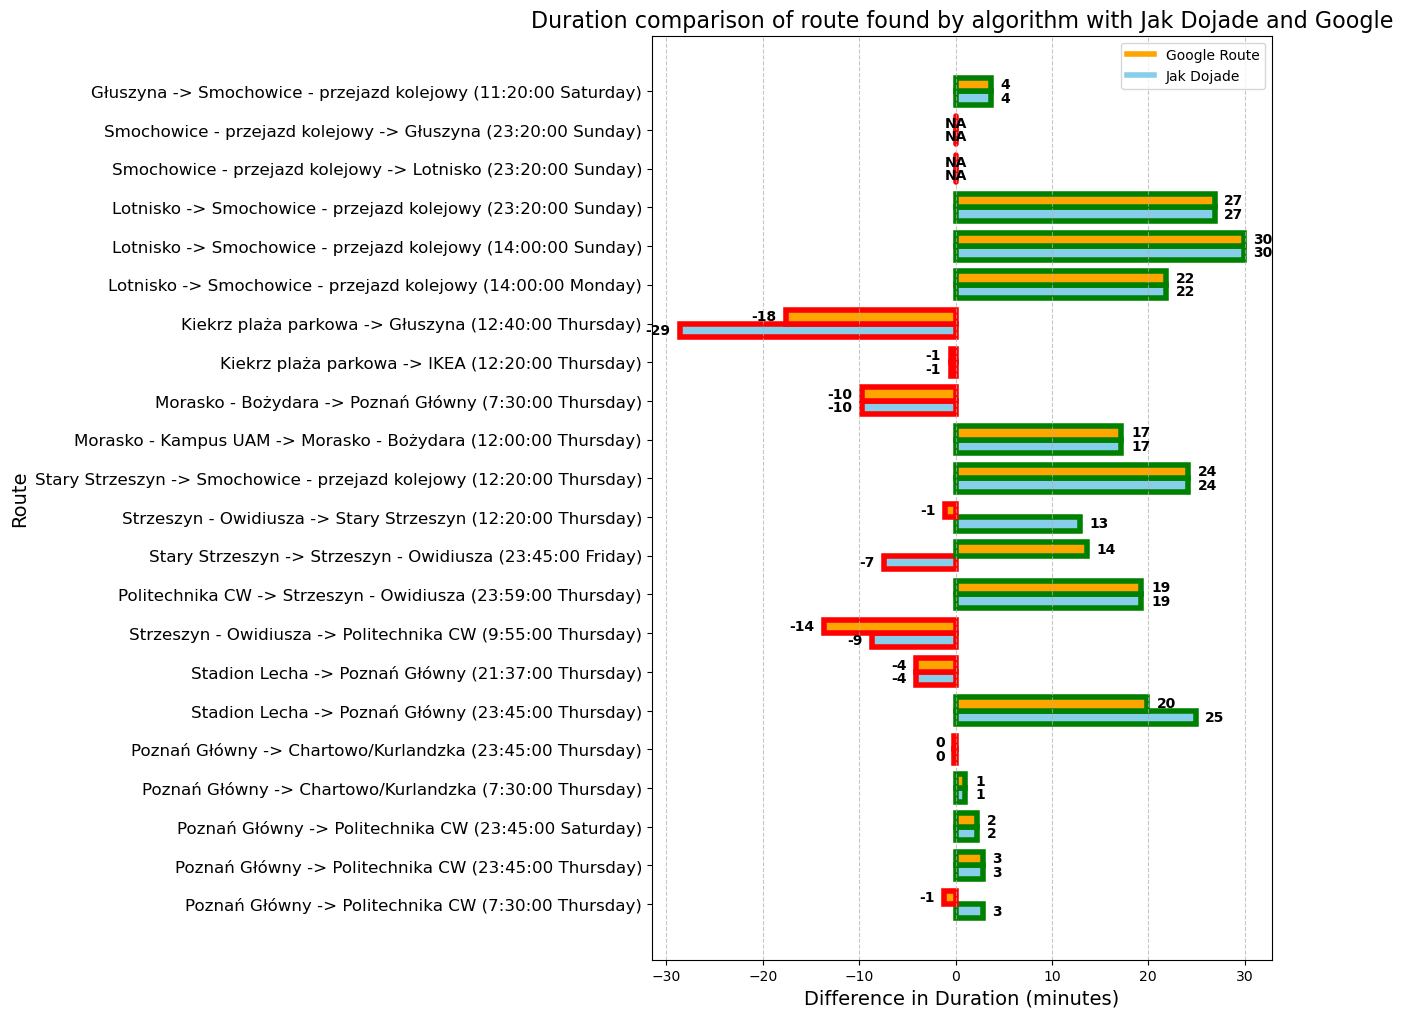

In [61]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 12))  # Increase the figure width

# Bar positions
bar_width = 0.35
index = range(len(df))

# Plot bars for Jak Dojade duration
bars1 = ax.barh([i - bar_width/2 for i in index], df['duration dojade - found route (min)'].fillna(0), bar_width, color='skyblue', edgecolor=['green' if x > 0 else 'red' for x in df['duration dojade - found route (min)'].fillna(0)], linewidth=1.5, label='Jak Dojade')

# Plot bars for Google route duration
bars2 = ax.barh([i + bar_width/2 for i in index], df['duration google - found route (min)'].fillna(0), bar_width, color='orange', edgecolor=['green' if x > 0 else 'red' for x in df['duration google - found route (min)'].fillna(0)], linewidth=1.5, label='Google Route')

# Round the corners of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        bar.set_edgecolor(bar.get_edgecolor())
        bar.set_linewidth(4)
        bar.set_path_effects([])  # Clear any existing path effects
        bar.set_clip_on(False)
        bar.set_capstyle('round')

ax.set_yticks(index)
ax.set_yticklabels(df['Label'], fontsize=12)

plt.ylabel('Route',fontsize=14)
plt.xlabel('Difference in Duration (minutes)', fontsize=14)
plt.title('Duration comparison of route found by algorithm with Jak Dojade and Google', fontsize=16)

# Add labels to bars
for bars, diffs in zip([bars1, bars2], [df['duration dojade - found route (min)'], df['duration google - found route (min)']]):
    for bar, diff in zip(bars, diffs):
        xval = bar.get_width()
        offset = 1  # Adjust this value to set the distance from the bar end
        if pd.isna(diff):
            plt.text(0, bar.get_y() + bar.get_height()/2, 'NA', ha='center', va='center', color='black', fontsize=10, fontweight='bold')
        else:
            if xval > 0:
                plt.text(xval + offset, bar.get_y() + bar.get_height()/2, round(xval), ha='left', va='center', color='black', fontsize=10, fontweight='bold')
            else:
                plt.text(xval - offset, bar.get_y() + bar.get_height()/2, round(xval), ha='right', va='center', color='black', fontsize=10, fontweight='bold')

legend_elements = [
    Line2D([0], [0], color='orange', lw=4, label='Google Route'),
    Line2D([0], [0], color='skyblue', lw=4, label='Jak Dojade')
    
]
ax.legend(handles=legend_elements)

plt.grid(axis='x', linestyle='--', alpha=0.7)
#plt.tight_layout()
plt.show()

## Searching time components

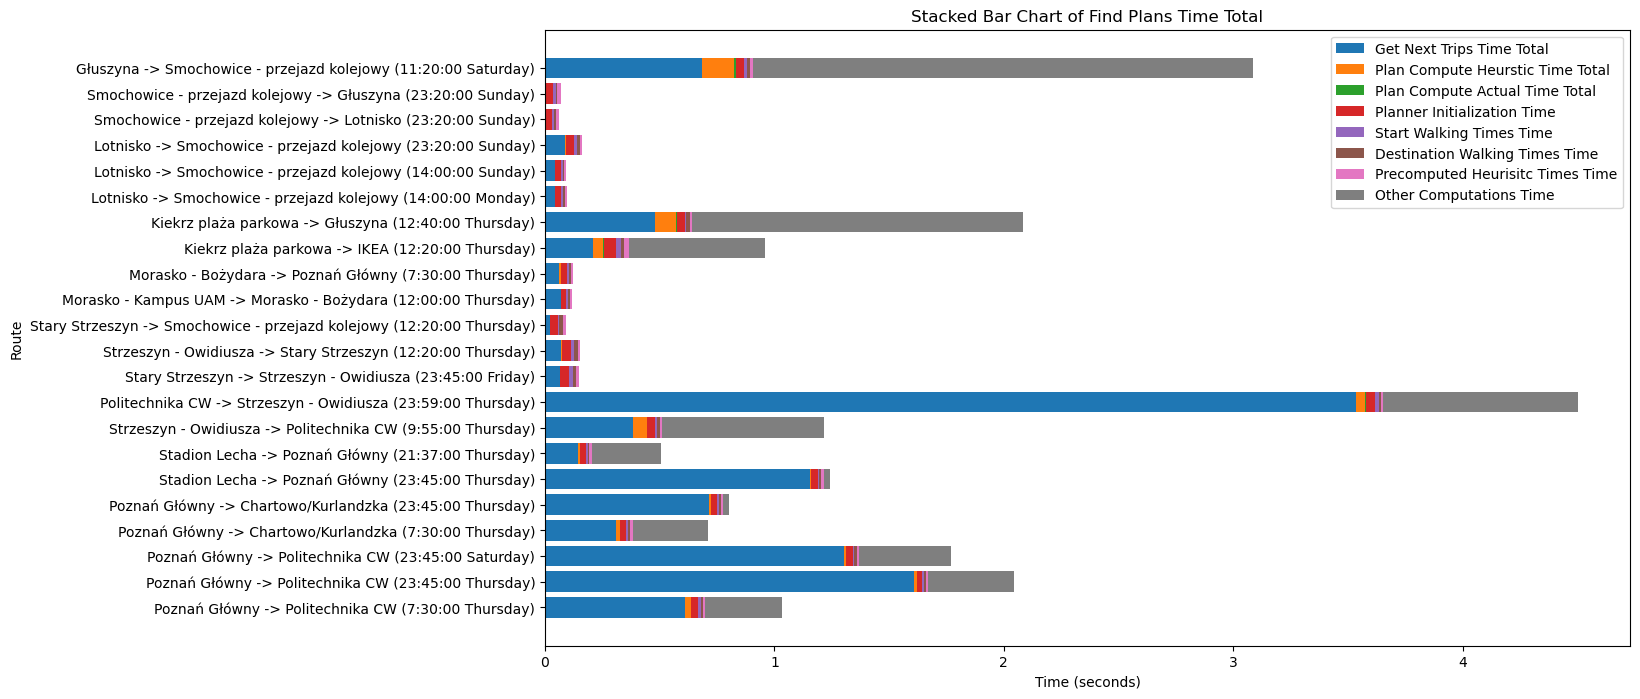

In [62]:
columns = [
    'get_next_trips_time_total',
    'plan_compute_heurstic_time_total',
    'plan_compute_actual_time_total',
    'planner_initialization_time',
    'start_walking_times_time',
    'destination_walking_times_time',
    'precomputed_heurisitc_times_time'
]

df['other_computations_time'] = df['find_plans_time_total'] - df[columns].sum(axis=1, skipna=True)

df['other_computations_time'] = df['other_computations_time'].apply(lambda x: max(x, 0))

fig, ax = plt.subplots(figsize=(14, 8))

bottom = pd.Series([0] * len(df))
for column in columns:
    if column in df:
        ax.barh(df['Label'], df[column], left=bottom, label=column.replace('_', ' ').title())
        bottom += df[column]

ax.barh(df['Label'], df['other_computations_time'], left=bottom, label='Other Computations Time')

plt.xlabel('Time (seconds)')
plt.ylabel('Route')
plt.title('Stacked Bar Chart of Find Plans Time Total')
plt.legend()

plt.show()

## Qulitative analysis of A* expansions

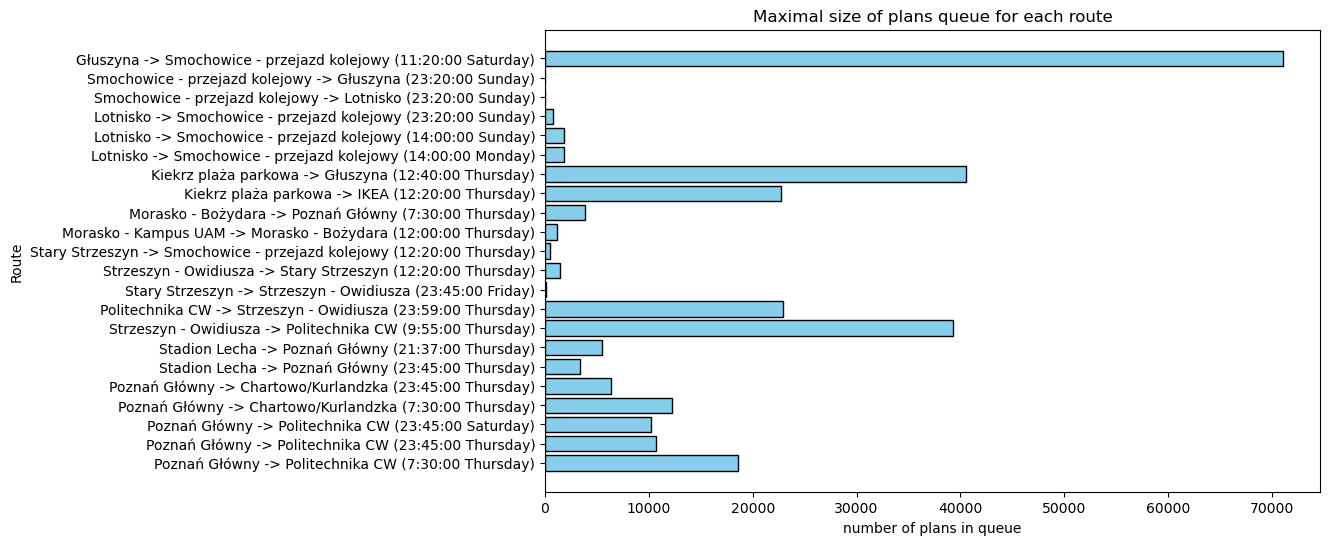

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(df['Label'], df['plans_queue_max_size'], color='skyblue', edgecolor='black')

plt.xlabel('number of plans in queue')
plt.ylabel('Route')
plt.title('Maximal size of plans queue for each route')

plt.show()

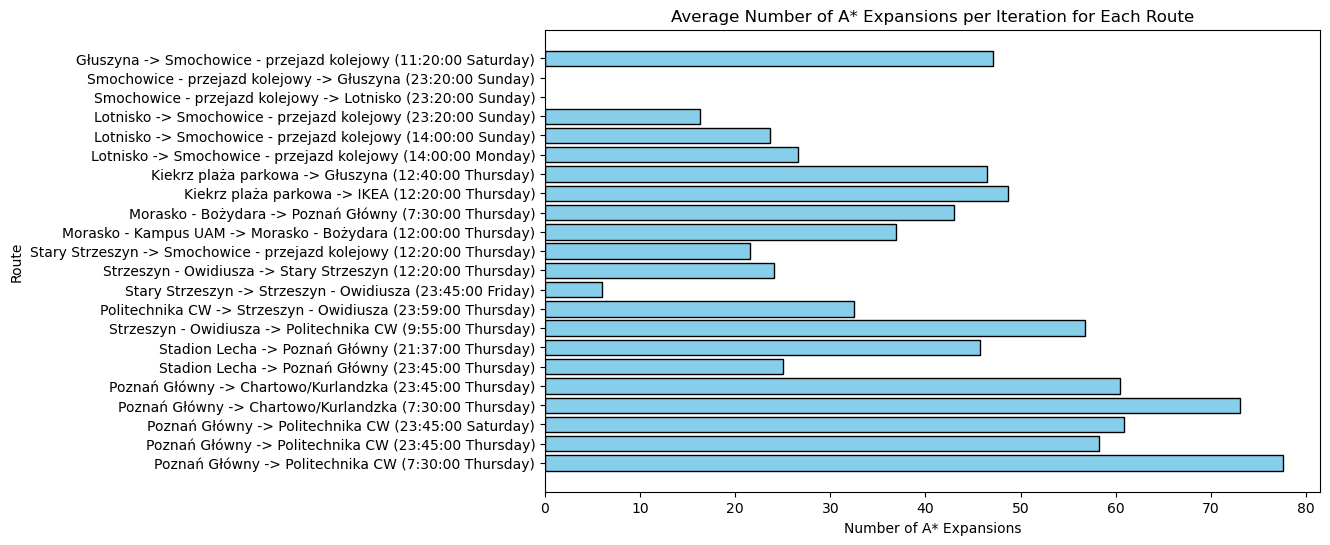

In [64]:
df['avg_expansions_per_iteration'] = df['expansions_total'] / df['iterations']

fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(df['Label'], df['avg_expansions_per_iteration'], color='skyblue', edgecolor='black')

plt.xlabel('Number of A* Expansions')
plt.ylabel('Route')
plt.title('Average Number of A* Expansions per Iteration for Each Route')

# Show plot
plt.show()

### The purpose of the next two plots is to get better understanding of how A* works in this application, rather than analysing performance

currently there is an issue with unique stops visited metric so its results are incorrect

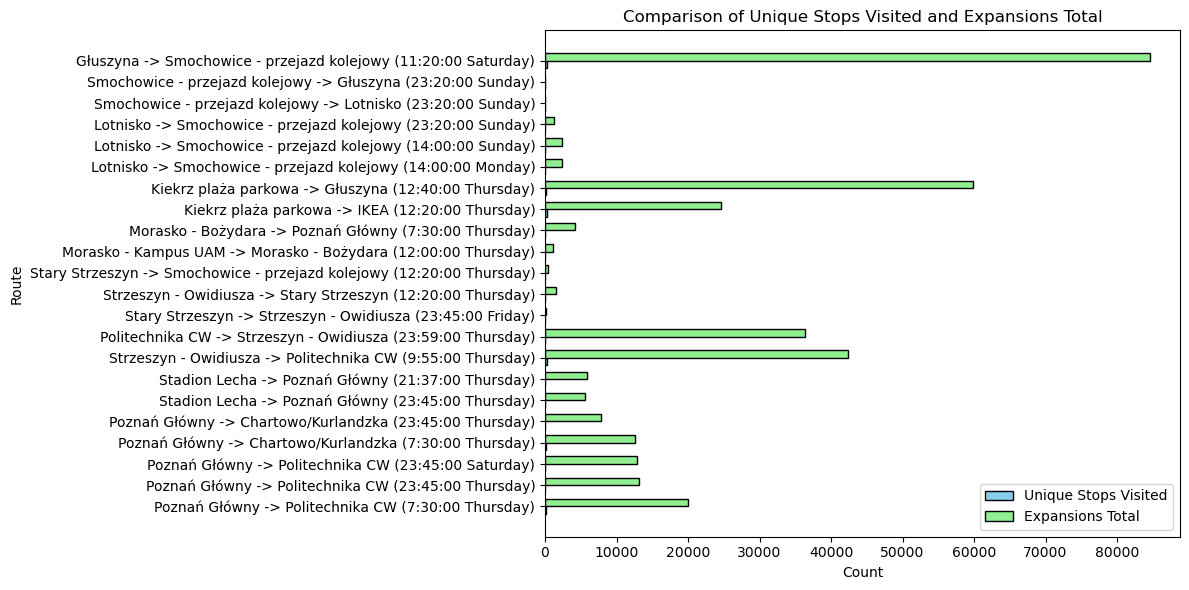

In [65]:
fig, ax = plt.subplots(figsize=(12, 6))

bar_height = 0.35

index = np.arange(len(df['Label']))

bars1 = ax.barh(index - bar_height/2, df['unique_stops_visited'], bar_height, label='Unique Stops Visited', color='skyblue', edgecolor='black')
bars2 = ax.barh(index + bar_height/2, df['expansions_total'], bar_height, label='Expansions Total', color='lightgreen', edgecolor='black')

ax.set_ylabel('Route')
ax.set_xlabel('Count')
ax.set_title('Comparison of Unique Stops Visited and Expansions Total')
ax.set_yticks(index)
ax.set_yticklabels(df['Label'])
ax.legend()

plt.tight_layout()
plt.show()

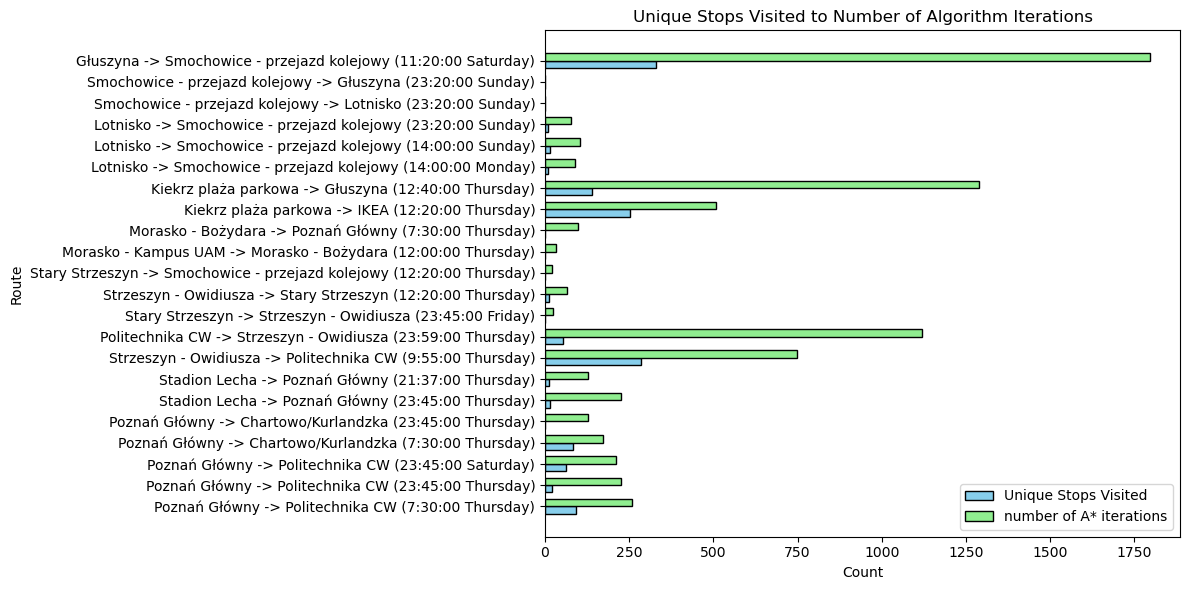

In [66]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Bar height
bar_height = 0.35

# Bar positions
index = np.arange(len(df['Label']))

# Create bars for unique_stops_visited
bars1 = ax.barh(index - bar_height/2, df['unique_stops_visited'], bar_height, label='Unique Stops Visited', color='skyblue', edgecolor='black')

# Create bars for expansions_total
bars2 = ax.barh(index + bar_height/2, df['iterations'], bar_height, label='number of A* iterations', color='lightgreen', edgecolor='black')

# Add labels and title
ax.set_ylabel('Route')
ax.set_xlabel('Count')
ax.set_title('Unique Stops Visited to Number of Algorithm Iterations')
ax.set_yticks(index)
ax.set_yticklabels(df['Label'])
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

# Saving analysis to PDF

In [ ]:
import copy
# Load the current notebook
notebook_filename = 'custom_benchmark_data_analysis.ipynb'
with open(notebook_filename) as f:
    nb = nbformat.read(f, as_version=4)

# Create a deep copy of the notebook to modify for export
nb_copy = copy.deepcopy(nb)

# Remove inputs of cells with 'hide_code' or 'hide_markdown' tags in the copy
nb_copy['cells'] = [cell for cell in nb_copy['cells'] if not (
    'tags' in cell['metadata'] and
    ('hide_all' in cell['metadata']['tags'] or 'hide_markdown' in cell['metadata']['tags'])
)]
for cell in nb_copy['cells']:
    if 'tags' in cell['metadata']:
        if 'hide_code' in cell['metadata']['tags']:
            cell['source'] = ''  # Clear the source to hide the input

# Configure the HTML exporter
html_exporter = HTMLExporter()

# Export the modified notebook copy to HTML
html_data, resources = html_exporter.from_notebook_node(nb_copy)

# Create the directory if it does not exist
output_dir = 'data_analysis_results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the HTML to a file in the specified directory
html_filename = os.path.join(output_dir, filename + '.html')
with open(html_filename, 'w') as f:
    f.write(html_data)

print(f'Notebook has been converted to HTML and saved as {html_filename}')

Notebook has been converted to HTML and saved as data_analysis\custom_benchmark_results2024-11-08_15-33-13-analysis.html
